In [1]:
import pandas as pd
import numpy as np
import tensorflow

In [2]:
from tensorflow import keras

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [5]:
from matplotlib import pyplot

In [6]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

In [7]:
from math import sqrt
from numpy import concatenate

In [8]:
dataset = pd.read_csv('../data/clean_data/df260_fewerCols.csv', header=0, index_col=0)

value = dataset.to_numpy()
value.shape

(7439, 32)

In [78]:
i = 0
for columns in dataset.columns:
    print(i,": "+ columns)
    i += 1

0 : Date
1 : Wind_Direction_Vector
2 : Avg_Temp
3 : Min_Temp
4 : Min_Temp_Hour
5 : Max_Temp
6 : Max_Temp_Hour
7 : Min_Temp_at_10cm
8 : Min_Temp_at_10cm_Hour
9 : Sunshine_Duration_by_radiation
10 : Percentage_of_Longest_Possible_Sunshine_Duration
11 : Global_Radiation
12 : Duration_of_Precipitation
13 : Time_sum_of_the_precipitation
14 : Highest_Hourly_Sum_of_Precipitation
15 : Highest_Hourly_Sum_of_Precipitation_Hour
16 : Time_average_air pressure_reduced_to_sea_level
17 : Highest_hourly_value_of_air_pressure_reduced_to_sea_level
18 : Highest_hourly_value_of_air_pressure_reduced_to_sea_level_hour
19 : Lowest_hourly_value_of_air_pressure_reduced_to_sea_level
20 : Lowest_hourly_value_of_air_pressure_reduced_to_sea_level_hour
21 : Minimum_encountered_visibility
22 : Minimum_encountered_visibility_hour
23 : Maximum_encountered_visibility
24 : Maximum_encountered_visibility_hour
25 : Time_average_cloud_cover
26 : Time_average_relative_humidity(percent)
27 : Maximum_relative_humidity(percent

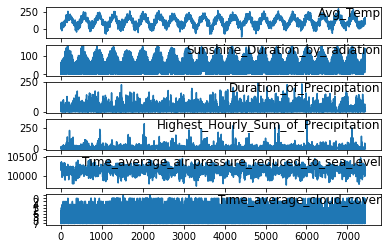

In [79]:
groups = [2,9,12,14,16,25]
i = 1
# plot each column
pyplot.figure()
for group in groups:

    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(value[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1

pyplot.show()

deleting the date since it doesn't fit the float format and also row 24 because they cant be transfered to float

In [17]:
values = np.delete(value,0,1)
values = np.delete(values,24,1)
values_backup = values

values.shape

(7439, 30)

In [10]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    print(df.shape)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    print(df.shape)

    # put it all together
    agg = pd.concat(cols, axis=1)
    print("df.shape: " ,df.shape)

    agg.columns = names
    


    # drop rows with NaN values
    agg.dropna(inplace=True)
    print("agg.shape:  ", agg.shape)
    return agg
 


In [36]:
values = values_backup

In [37]:
print(values.shape)

# integer encode direction
encoder = LabelEncoder()
values[:,29] = encoder.fit_transform(values[:,29])
# ensure all data is float
values = values.astype('float32')
# normalize features

values.shape
scaler = MinMaxScaler(feature_range=(0, 1))

scaled = scaler.fit_transform(values)
print(scaled.shape)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[30,32,33,34,35,35,36,37,38,
                                39,40,41,42,43,44,45,46,47,48,
                                49,50,51,52,53,54,55,56,57,58,59]], axis=1, inplace=True)

print(reframed.head())

(7439, 30)
(7439, 30)
(7439, 30)
(7439, 30)
df.shape:  (7439, 30)
agg.shape:   (7438, 60)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.657382   0.435407   0.542373   0.782609   0.325688   0.478261   
2   0.568245   0.464115   0.588378   0.000000   0.339450   0.739130   
3   0.587744   0.490431   0.612591   1.000000   0.360092   0.521739   
4   0.640669   0.442584   0.561743   0.304348   0.355505   0.652174   
5   0.529248   0.394737   0.491525   0.347826   0.309633   0.565217   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var22(t-1)  var23(t-1)  \
1   0.458333   1.000000   0.000000    0.000000  ...    0.347826    0.746988   
2   0.604167   0.000000   0.000000    0.000000  ...    0.217391    0.590361   
3   0.655093   1.000000   0.000000    0.000000  ...    0.652174    0.734940   
4   0.567130   1.000000   0.000000    0.000000  ...    0.391304    0.951807   
5   0.456019   0.333333   0.419355    0.863158  ...    0.347826    0.891566   

   var24

In [47]:
# split into train and test sets
values = reframed.values
n_train_days = 6000
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs

train_X = np.delete(train,1,1)
train_y = train[:,1]

test_X = np.delete(test,1,1)
test_y = test[:,1]



#train_X, train_y = train[:, :-1], train[:, -1]
#test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(6000, 1, 30) (6000,) (1438, 1, 30) (1438,)


Train on 6000 samples, validate on 1438 samples
Epoch 1/50
6000/6000 - 4s - loss: 0.1359 - val_loss: 0.0720
Epoch 2/50
6000/6000 - 1s - loss: 0.0588 - val_loss: 0.0407
Epoch 3/50
6000/6000 - 1s - loss: 0.0349 - val_loss: 0.0296
Epoch 4/50
6000/6000 - 1s - loss: 0.0262 - val_loss: 0.0216
Epoch 5/50
6000/6000 - 0s - loss: 0.0204 - val_loss: 0.0177
Epoch 6/50
6000/6000 - 0s - loss: 0.0178 - val_loss: 0.0156
Epoch 7/50
6000/6000 - 0s - loss: 0.0165 - val_loss: 0.0146
Epoch 8/50
6000/6000 - 1s - loss: 0.0149 - val_loss: 0.0136
Epoch 9/50
6000/6000 - 0s - loss: 0.0141 - val_loss: 0.0130
Epoch 10/50
6000/6000 - 0s - loss: 0.0136 - val_loss: 0.0127
Epoch 11/50
6000/6000 - 0s - loss: 0.0132 - val_loss: 0.0125
Epoch 12/50
6000/6000 - 0s - loss: 0.0134 - val_loss: 0.0124
Epoch 13/50
6000/6000 - 1s - loss: 0.0133 - val_loss: 0.0131
Epoch 14/50
6000/6000 - 1s - loss: 0.0126 - val_loss: 0.0120
Epoch 15/50
6000/6000 - 1s - loss: 0.0123 - val_loss: 0.0116
Epoch 16/50
6000/6000 - 1s - loss: 0.0126 - va

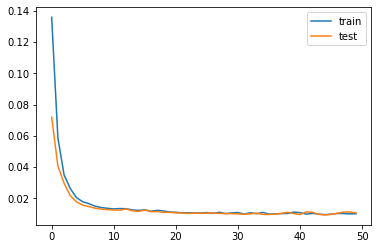

In [48]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [49]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.810
